In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from datetime import datetime, timedelta
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('ggplot')
sns.set(style="whitegrid")

In [26]:
# Define time range
end_date = datetime.now()
start_date = end_date - timedelta(days=730)  # About 2 years of data

# Use yfinance to get Bitcoin and Ethereum price data
btc_data = yf.download('BTC-USD', start=start_date, end=end_date)
eth_data = yf.download('ETH-USD', start=start_date, end=end_date)

# View the first few rows of Bitcoin data
print("Bitcoin price data sample:")
btc_data.head()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Bitcoin price data sample:


Price,Close,High,Low,Open,Volume
Ticker,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD
Date,,,,,
2023-04-22,27817.500000,27872.142578,27169.570312,27265.894531,13125734602
2023-04-23,27591.384766,27820.244141,27400.314453,27816.144531,12785446832
2023-04-24,27525.339844,27979.982422,27070.849609,27591.730469,17703288330
2023-04-25,28307.597656,28371.078125,27207.931641,27514.873047,17733373139
2023-04-26,28422.701172,29995.837891,27324.548828,28300.058594,31854242019


In [27]:
# First check what columns actually exist in the dataframe
print("btc_data column names:")
print(btc_data.columns.tolist())

# Also check if the dataframe is empty
print("\nbtc_data shape:", btc_data.shape)
print("\nbtc_data first few rows:")
print(btc_data.head())

btc_data column names:
[('Close', 'BTC-USD'), ('High', 'BTC-USD'), ('Low', 'BTC-USD'), ('Open', 'BTC-USD'), ('Volume', 'BTC-USD')]

btc_data shape: (731, 5)

btc_data first few rows:
Price              Close          High           Low          Open  \
Ticker           BTC-USD       BTC-USD       BTC-USD       BTC-USD   
Date                                                                 
2023-04-22  27817.500000  27872.142578  27169.570312  27265.894531   
2023-04-23  27591.384766  27820.244141  27400.314453  27816.144531   
2023-04-24  27525.339844  27979.982422  27070.849609  27591.730469   
2023-04-25  28307.597656  28371.078125  27207.931641  27514.873047   
2023-04-26  28422.701172  29995.837891  27324.548828  28300.058594   

Price            Volume  
Ticker          BTC-USD  
Date                     
2023-04-22  13125734602  
2023-04-23  12785446832  
2023-04-24  17703288330  
2023-04-25  17733373139  
2023-04-26  31854242019  


Bitcoin price data information:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 731 entries, 2023-04-22 to 2025-04-21
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   (Close, BTC-USD)   731 non-null    float64
 1   (High, BTC-USD)    731 non-null    float64
 2   (Low, BTC-USD)     731 non-null    float64
 3   (Open, BTC-USD)    731 non-null    float64
 4   (Volume, BTC-USD)  731 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 34.3 KB

Missing value check:
Price   Ticker 
Close   BTC-USD    0
High    BTC-USD    0
Low     BTC-USD    0
Open    BTC-USD    0
Volume  BTC-USD    0
dtype: int64

Basic statistical description:
Columns after calculating returns: [('Close', 'BTC-USD'), ('High', 'BTC-USD'), ('Low', 'BTC-USD'), ('Open', 'BTC-USD'), ('Volume', 'BTC-USD'), ('Returns', '')]


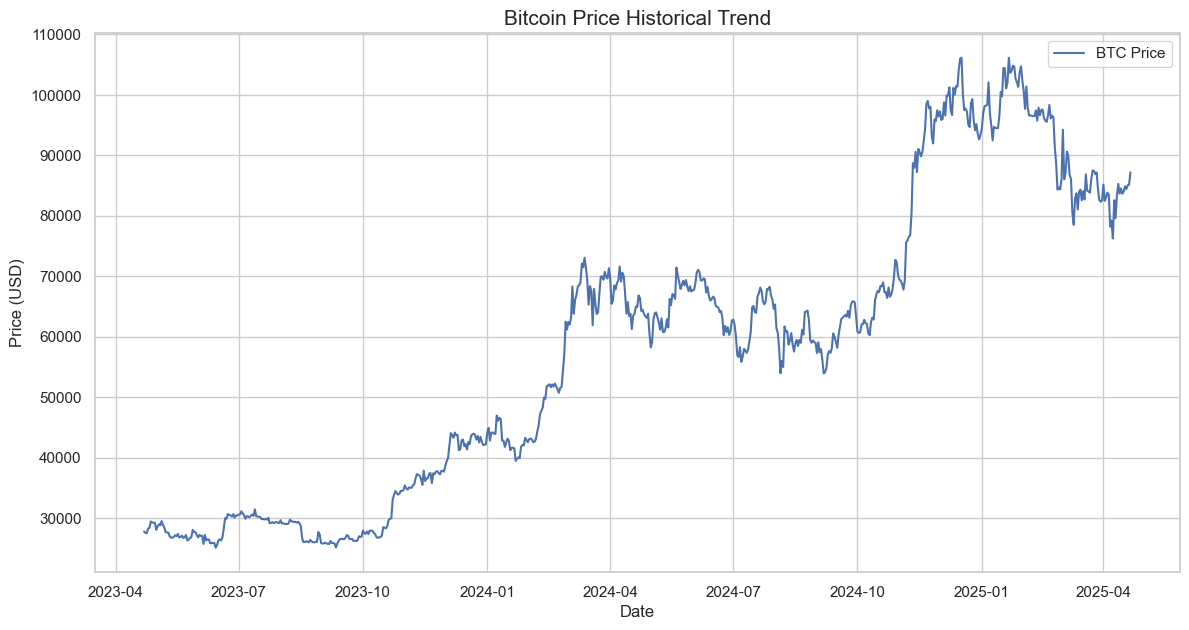

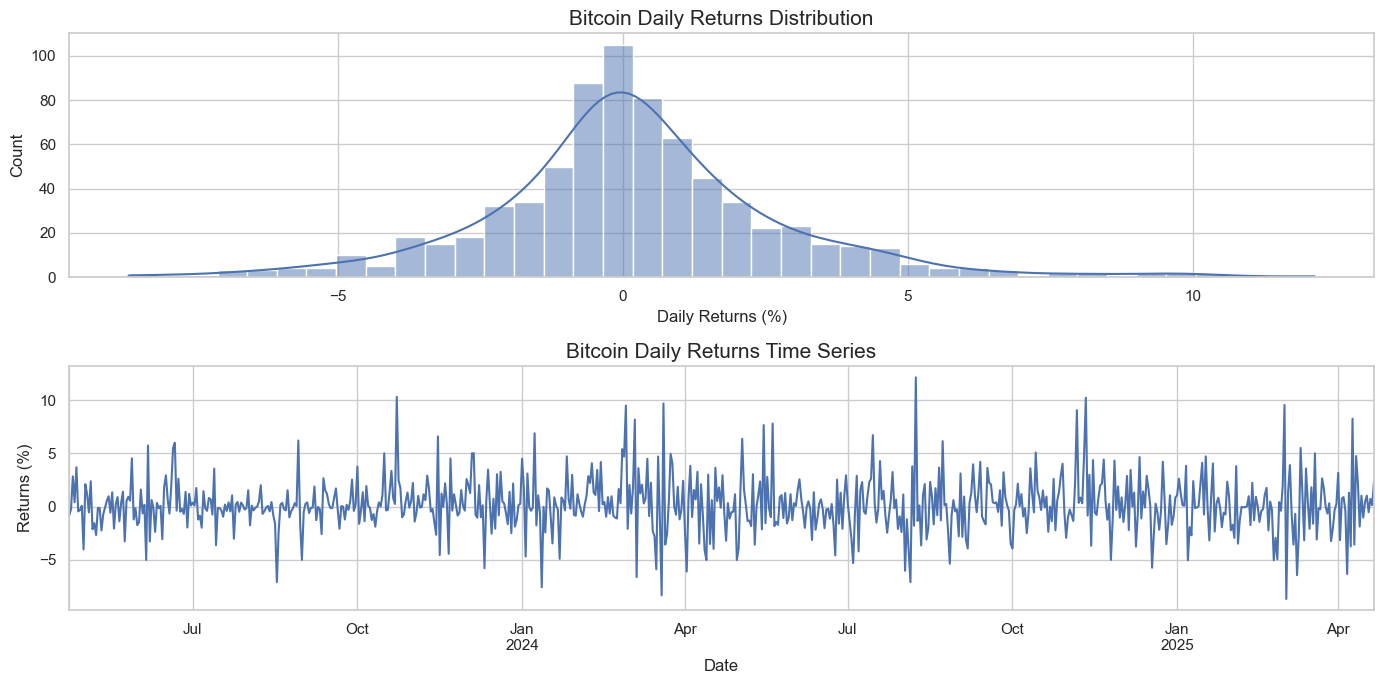

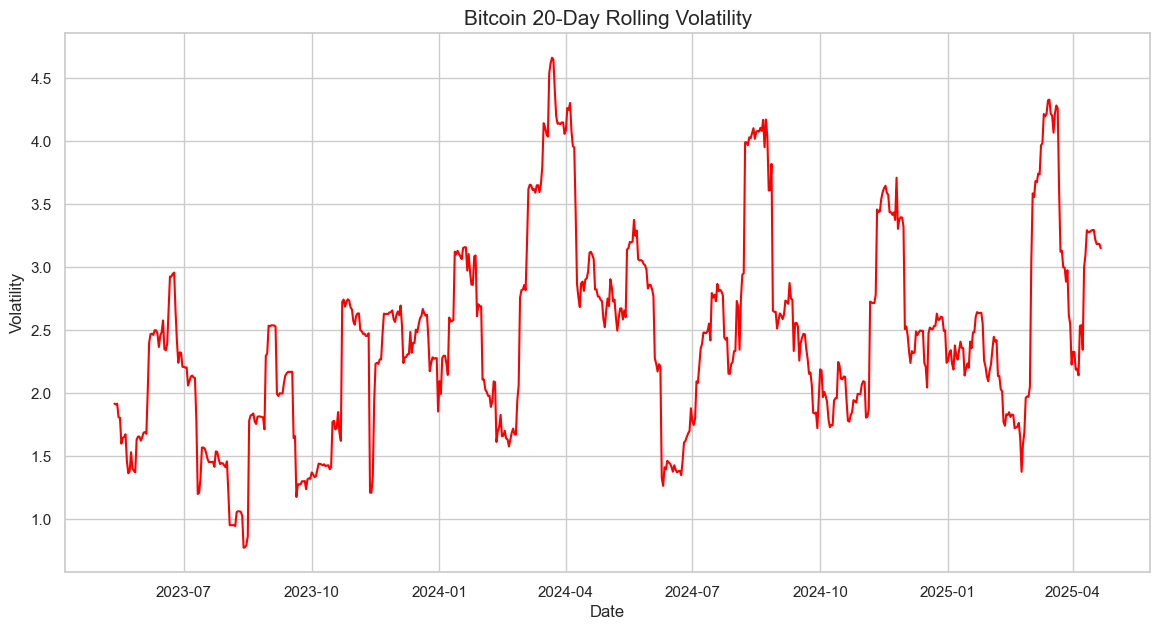

In [28]:
# Check basic information about the data
print("Bitcoin price data information:")
btc_data.info()

# Check for missing values
print("\nMissing value check:")
print(btc_data.isnull().sum())

# Basic statistical description
print("\nBasic statistical description:")
btc_data.describe()

# If there is a 'Close' column
btc_data['Returns'] = btc_data['Close'].pct_change() * 100
eth_data['Returns'] = eth_data['Close'].pct_change() * 100

# Display modified columns
print("Columns after calculating returns:", btc_data.columns.tolist())

# Plot price time series
plt.figure(figsize=(14, 7))
plt.plot(btc_data.index, btc_data['Close'], label='BTC Price')
plt.title('Bitcoin Price Historical Trend', fontsize=15)
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

# Plot return distribution
plt.figure(figsize=(14, 7))
plt.subplot(2, 1, 1)
sns.histplot(btc_data['Returns'].dropna(), kde=True)
plt.title('Bitcoin Daily Returns Distribution', fontsize=15)
plt.xlabel('Daily Returns (%)')

plt.subplot(2, 1, 2)
btc_data['Returns'].dropna().plot(kind='line')
plt.title('Bitcoin Daily Returns Time Series', fontsize=15)
plt.xlabel('Date')
plt.ylabel('Returns (%)')
plt.tight_layout()
plt.show()

# Calculate volatility (20-day rolling standard deviation)
btc_data['Volatility'] = btc_data['Returns'].rolling(window=20).std()

# Plot volatility
plt.figure(figsize=(14, 7))
plt.plot(btc_data.index, btc_data['Volatility'], color='red')
plt.title('Bitcoin 20-Day Rolling Volatility', fontsize=15)
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.grid(True)
plt.show()

Starting cryptocurrency sentiment and price data exploratory analysis...

Analyzing dataset: Final Data

Loading df_Final.csv...
Successfully loaded data using semicolon as delimiter.

1. Final Data basic information:
   Rows: 12936, Columns: 16

   Data types and non-null counts:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12936 entries, 0 to 12935
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Date                    12936 non-null  object 
 1   Compound_Score          12358 non-null  float64
 2   Total Volume of Tweets  12358 non-null  float64
 3   Count_Negatives         12358 non-null  float64
 4   Count_Positives         12358 non-null  float64
 5   Count_Neutrals          12358 non-null  float64
 6   Sent_Negatives          12358 non-null  float64
 7   Sent_Positives          12357 non-null  float64
 8   Count_News              12358 non-null  float64
 9   Count_Bots           

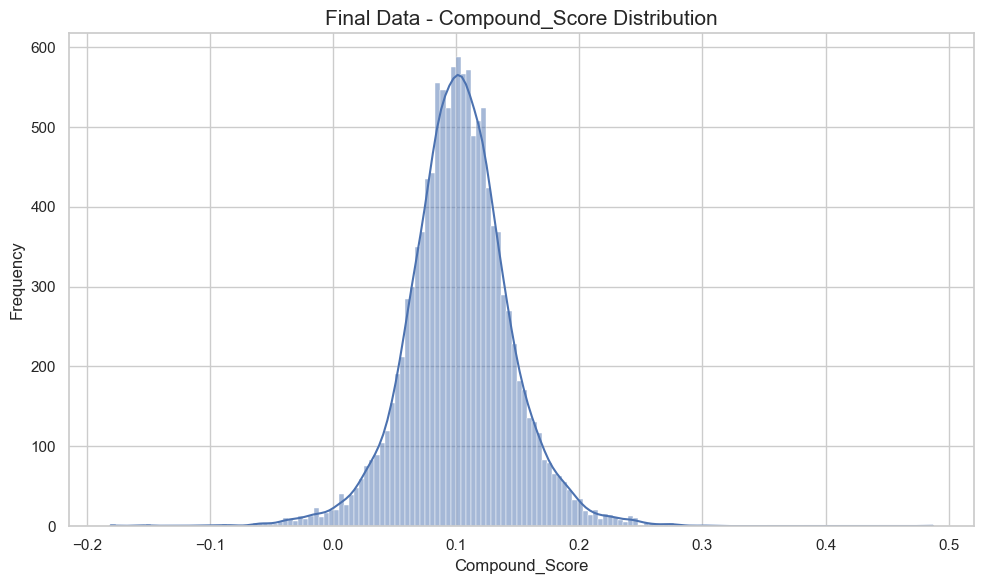

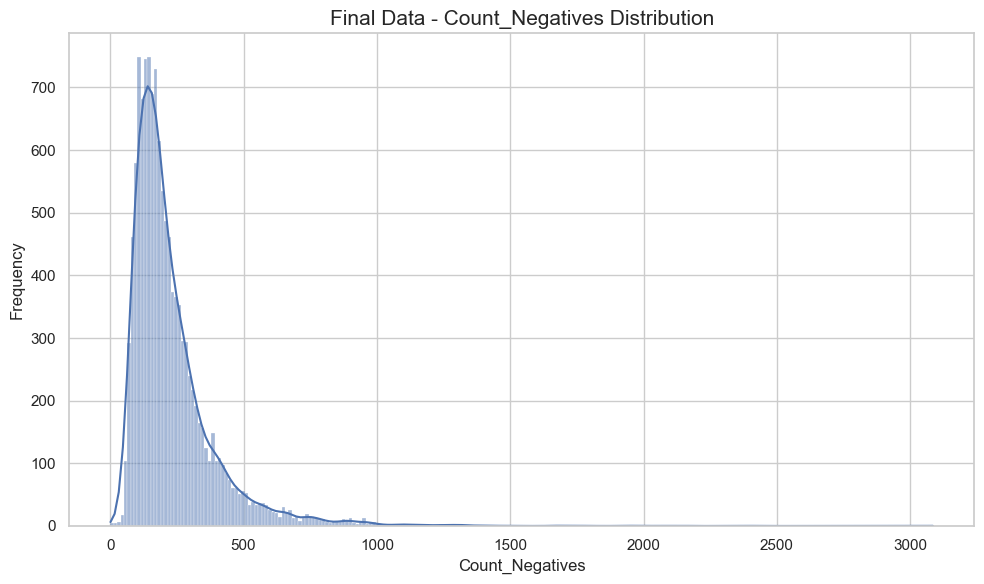

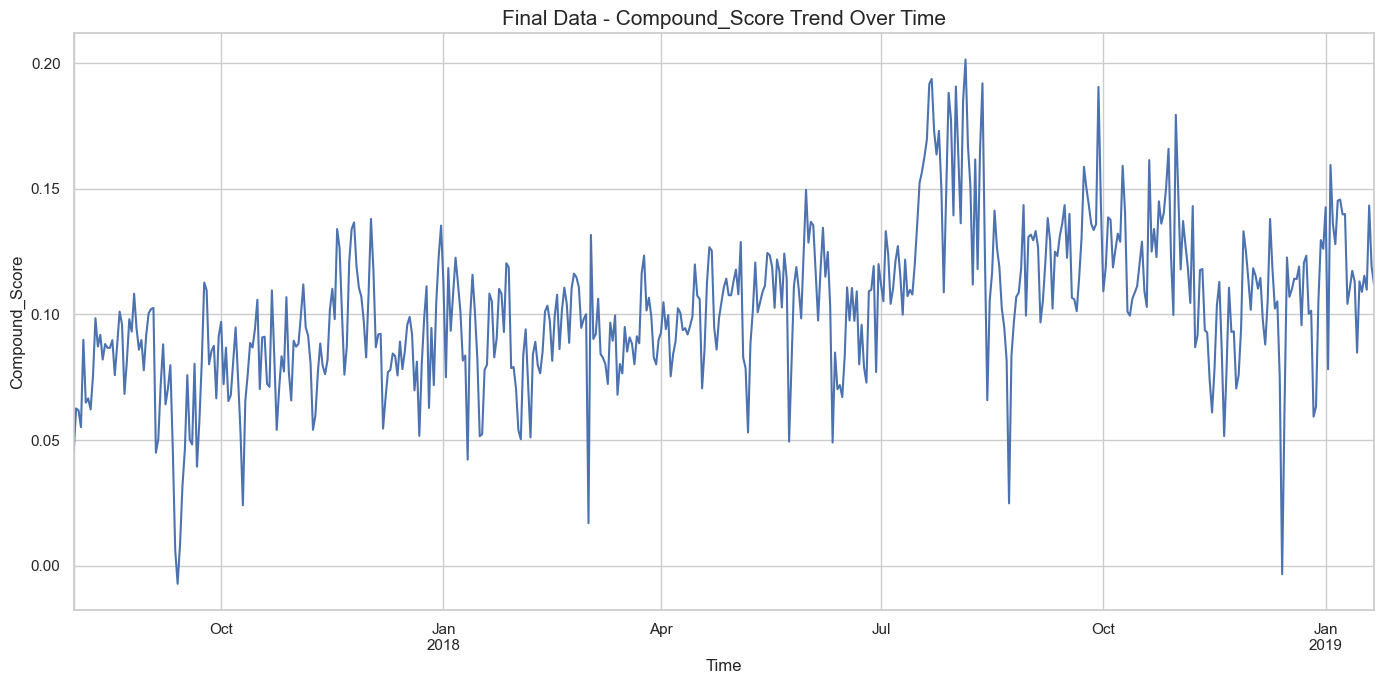

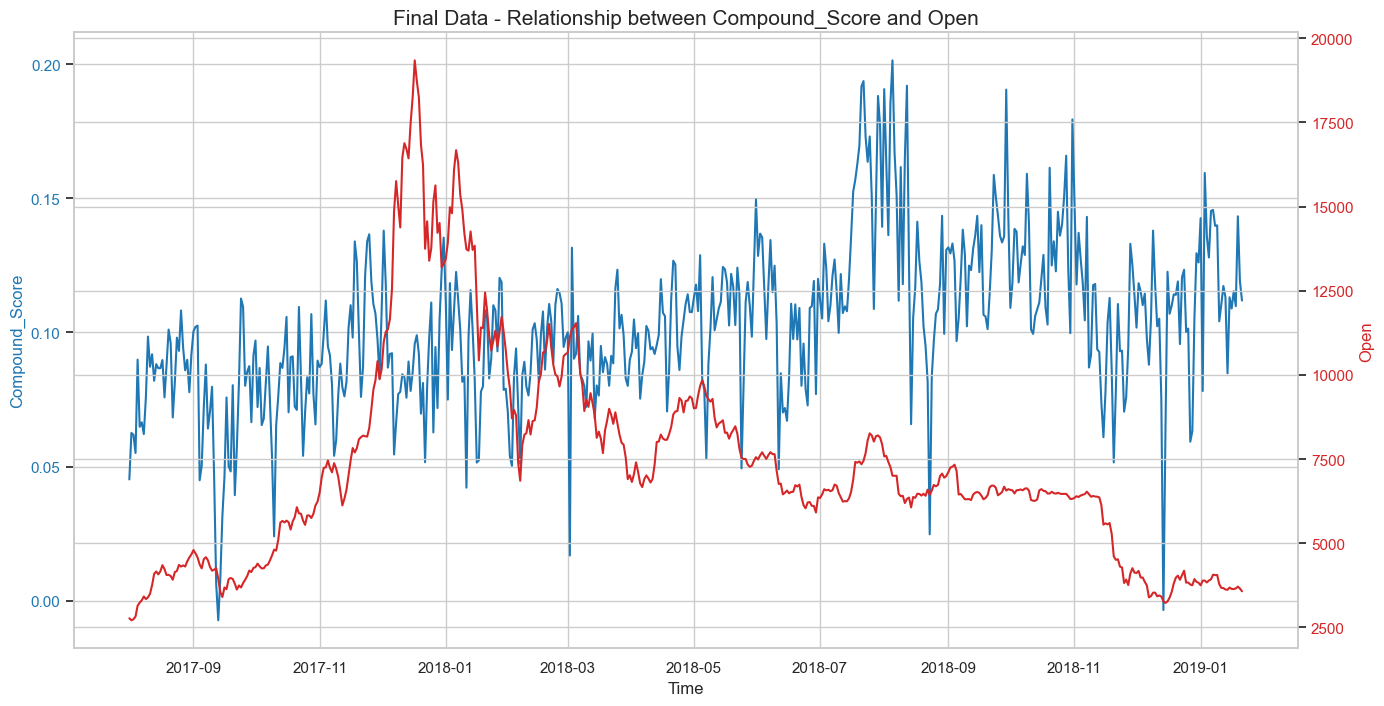


6. Correlation coefficient between Compound_Score and Open: 0.0015


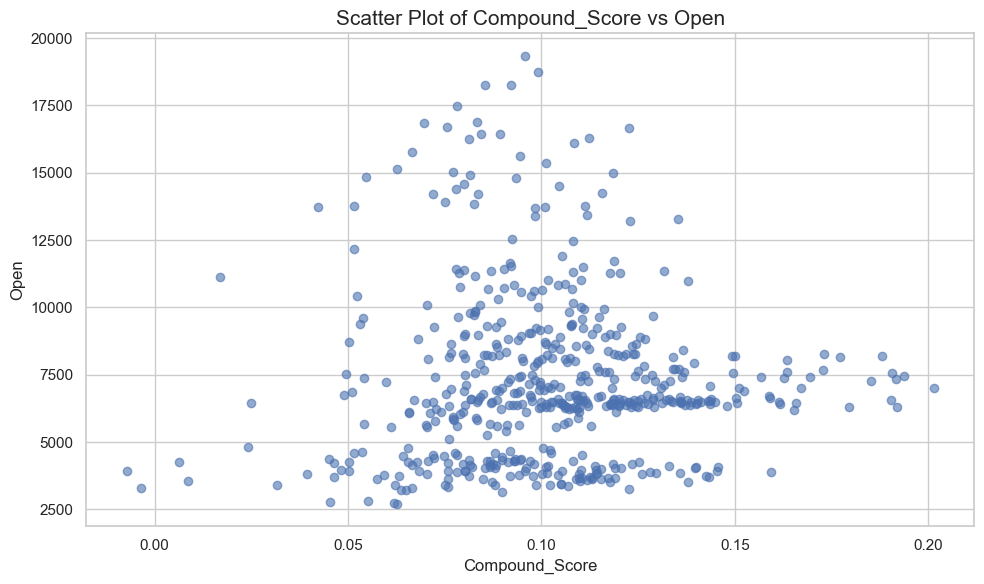


Analyzing dataset: Hourly Data

Loading Data_To_Hourervals_no_filter.csv...
Successfully loaded data using semicolon as delimiter.

1. Hourly Data basic information:
   Rows: 12936, Columns: 14

   Data types and non-null counts:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12936 entries, 0 to 12935
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Date               12936 non-null  object 
 1   Compound_Score     12362 non-null  float64
 2   n                  12665 non-null  float64
 3   Count_Negatives    12665 non-null  float64
 4   Count_Positives    12665 non-null  float64
 5   Count_Neutrals     12665 non-null  float64
 6   Sent_Negatives     12358 non-null  float64
 7   Sent_Positives     12358 non-null  float64
 8   Open               12936 non-null  float64
 9   High               12936 non-null  float64
 10  Low                12936 non-null  float64
 11  Close              12936 non-nu

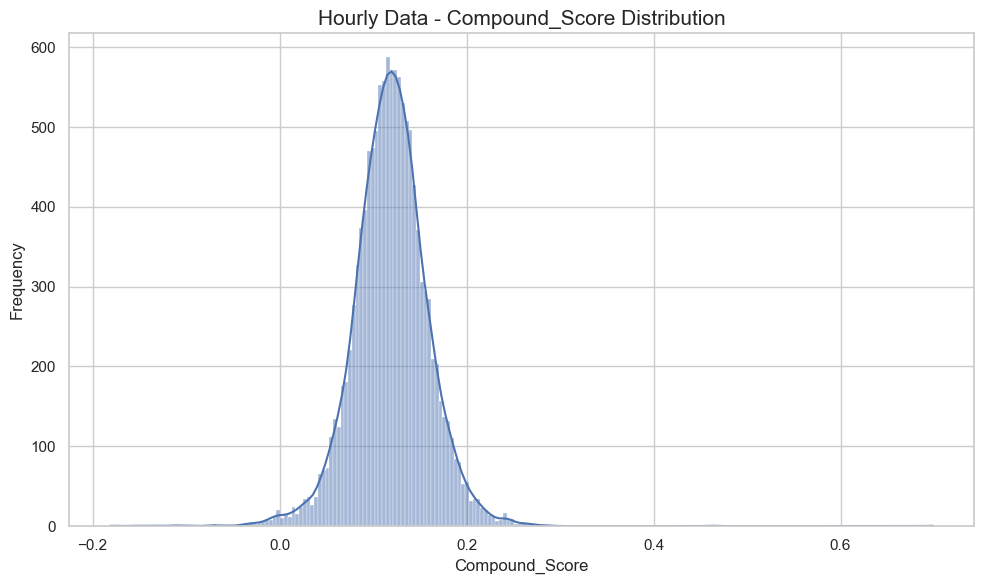

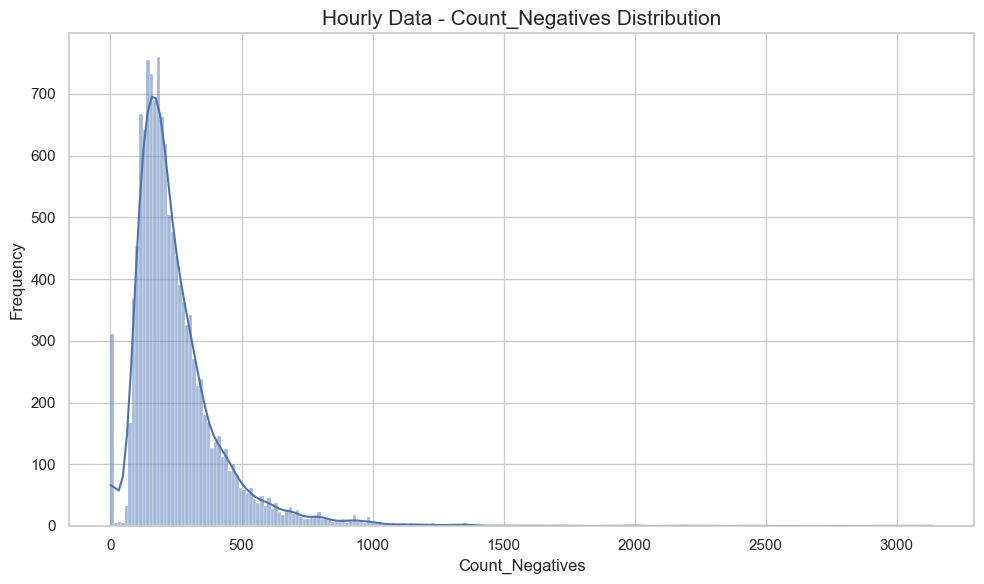

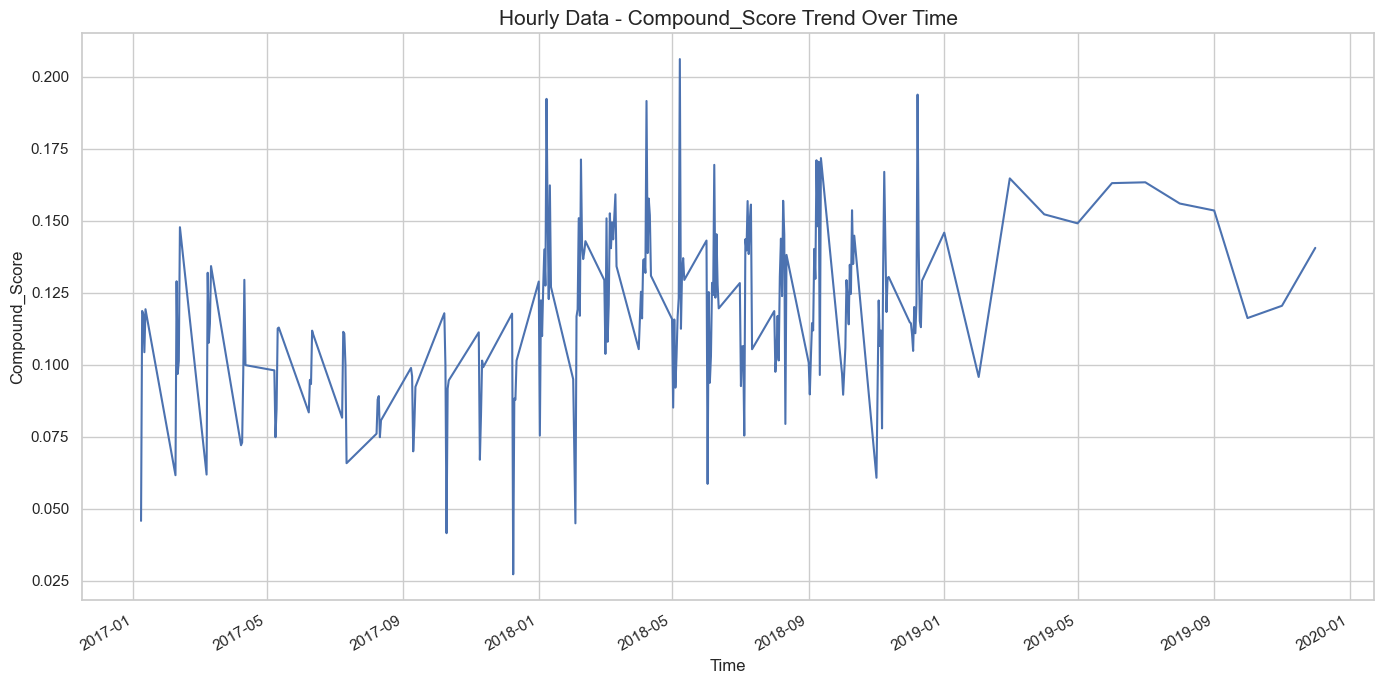

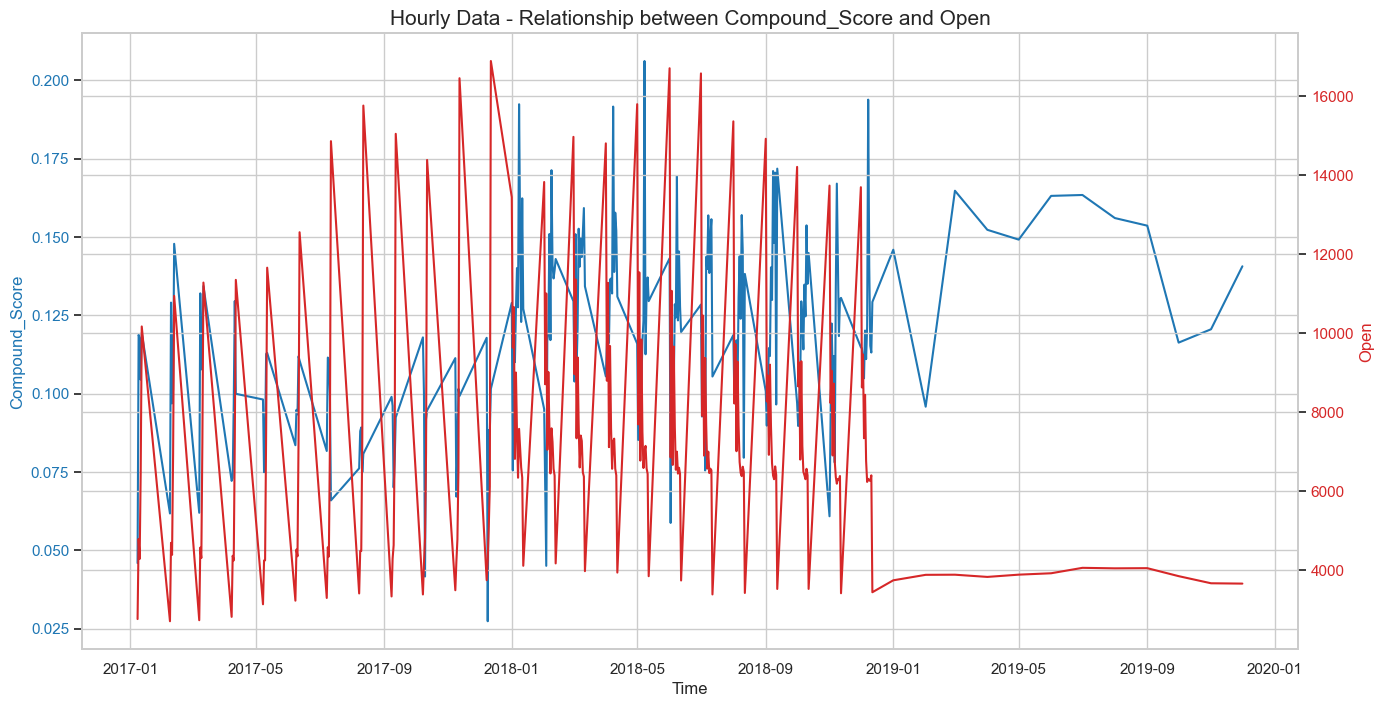


6. Correlation coefficient between Compound_Score and Open: -0.0629


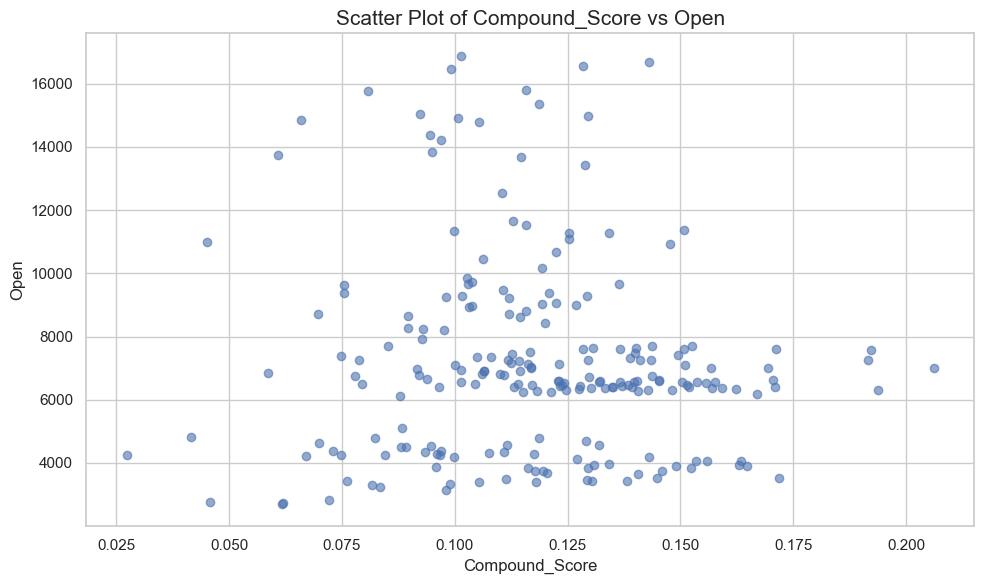


Exploratory data analysis completed!


In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('ggplot')
sns.set(style="whitegrid")

def explore_dataset(filepath, name):
    print(f"\n{'='*50}")
    print(f"Analyzing dataset: {name}")
    print(f"{'='*50}")
    
    # Load data using semicolon as separator
    print(f"\nLoading {filepath}...")
    try:
        df = pd.read_csv(filepath, sep=';', encoding='utf-8')
        print(f"Successfully loaded data using semicolon as delimiter.")
    except Exception as e:
        print(f"Failed to load with semicolon delimiter: {e}")
        try:
            # Try more flexible method
            df = pd.read_csv(filepath, sep=';', encoding='utf-8', error_bad_lines=False, warn_bad_lines=True)
            print(f"Successfully loaded data (ignoring error lines).")
        except Exception as e2:
            print(f"All loading methods failed: {e2}")
            return pd.DataFrame()
    
    # 1. Basic data information
    print(f"\n1. {name} basic information:")
    print(f"   Rows: {df.shape[0]}, Columns: {df.shape[1]}")
    print("\n   Data types and non-null counts:")
    print(df.info())
    
    # 2. Display first few rows
    print(f"\n2. {name} data samples (first 5 rows):")
    print(df.head())
    
    # 3. Column name analysis
    print(f"\n3. {name} column analysis:")
    columns = df.columns.tolist()
    print(f"   Column names: {columns}")
    
    # 4. Find potential key columns
    # Look for sentiment-related columns
    sentiment_cols = [col for col in columns if any(term in col.lower() for term in ['sentiment', 'emotion', 'score', 'compound', 'positive', 'negative'])]
    print(f"\n4.1 Potential sentiment columns: {sentiment_cols if sentiment_cols else 'Not found'}")
    
    # Look for date/time-related columns
    date_cols = [col for col in columns if any(term in col.lower() for term in ['date', 'time', 'day', 'hour', 'timestamp'])]
    print(f"4.2 Potential time columns: {date_cols if date_cols else 'Not found'}")
    
    # Look for price-related columns
    price_cols = [col for col in columns if any(term in col.lower() for term in ['price', 'value', 'close', 'open', 'high', 'low'])]
    print(f"4.3 Potential price columns: {price_cols if price_cols else 'Not found'}")
    
    # 5. Data distribution analysis
    # Statistical analysis of numerical columns
    numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
    if numerical_cols:
        print(f"\n5.1 Statistical analysis of numerical columns:")
        print(df[numerical_cols].describe())
    
    # 6. Visualization analysis
    # If sentiment columns are found, plot their distribution
    if sentiment_cols:
        for col in sentiment_cols[:2]:  # Limit to analyzing only the first two sentiment columns
            plt.figure(figsize=(10, 6))
            if df[col].dtype == 'object':  # Use count plot for categorical data
                df[col].value_counts().head(10).plot(kind='bar')
            else:  # Use histogram for numerical data
                sns.histplot(df[col].dropna(), kde=True)
            plt.title(f'{name} - {col} Distribution', fontsize=15)
            plt.xlabel(col)
            plt.ylabel('Frequency')
            plt.tight_layout()
            plt.show()
    
    # If both date and sentiment columns are found, plot time series
    if date_cols and sentiment_cols:
        try:
            date_col = date_cols[0]
            sentiment_col = sentiment_cols[0]
            
            # Try to convert date column
            if df[date_col].dtype == 'object':
                df[date_col] = pd.to_datetime(df[date_col], errors='coerce')
            
            # Check if conversion was successful
            if pd.api.types.is_datetime64_any_dtype(df[date_col]):
                # Aggregate sentiment data by date
                time_unit = 'D'  # Default to aggregate by day
                
                # If there are too many data points, consider aggregating by day
                if df[date_col].nunique() > 100:
                    df['date_truncated'] = df[date_col].dt.floor(time_unit)
                    time_series = df.groupby('date_truncated')[sentiment_col].mean()
                else:
                    time_series = df.groupby(date_col)[sentiment_col].mean()
                
                plt.figure(figsize=(14, 7))
                time_series.plot()
                plt.title(f'{name} - {sentiment_col} Trend Over Time', fontsize=15)
                plt.xlabel('Time')
                plt.ylabel(sentiment_col)
                plt.grid(True)
                plt.tight_layout()
                plt.show()
                
                # If price data is also available, plot the relationship between price and sentiment
                if price_cols:
                    price_col = price_cols[0]
                    
                    # Create price data aggregated by date
                    if 'date_truncated' in df.columns:
                        price_series = df.groupby('date_truncated')[price_col].mean()
                    else:
                        price_series = df.groupby(date_col)[price_col].mean()
                    
                    # Create dual Y-axis chart
                    fig, ax1 = plt.subplots(figsize=(14, 7))
                    
                    color = 'tab:blue'
                    ax1.set_xlabel('Time')
                    ax1.set_ylabel(sentiment_col, color=color)
                    ax1.plot(time_series.index, time_series.values, color=color)
                    ax1.tick_params(axis='y', labelcolor=color)
                    
                    ax2 = ax1.twinx()
                    color = 'tab:red'
                    ax2.set_ylabel(price_col, color=color)
                    ax2.plot(price_series.index, price_series.values, color=color) 
                    ax2.tick_params(axis='y', labelcolor=color)
                    
                    fig.tight_layout()
                    plt.title(f'{name} - Relationship between {sentiment_col} and {price_col}', fontsize=15)
                    plt.grid(True)
                    plt.show()
                    
                    # Calculate correlation
                    # Ensure both series have the same index
                    aligned_data = pd.merge(
                        pd.DataFrame(time_series),
                        pd.DataFrame(price_series),
                        left_index=True, right_index=True,
                        how='inner'
                    )
                    
                    if not aligned_data.empty:
                        correlation = aligned_data[sentiment_col].corr(aligned_data[price_col])
                        print(f"\n6. Correlation coefficient between {sentiment_col} and {price_col}: {correlation:.4f}")
                        
                        # Plot scatter plot
                        plt.figure(figsize=(10, 6))
                        plt.scatter(aligned_data[sentiment_col], aligned_data[price_col], alpha=0.6)
                        plt.title(f'Scatter Plot of {sentiment_col} vs {price_col}', fontsize=15)
                        plt.xlabel(sentiment_col)
                        plt.ylabel(price_col)
                        plt.grid(True)
                        plt.tight_layout()
                        plt.show()
        except Exception as e:
            print(f"Time series analysis error: {e}")
    
    return df

# Analyze two datasets
print("Starting cryptocurrency sentiment and price data exploratory analysis...")

# First analyze the final processed data
try:
    df_final = explore_dataset('df_Final.csv', 'Final Data')
except Exception as e:
    print(f"Unable to load or analyze df_Final.csv: {e}")

# Then analyze the raw data
try:
    df_hourly = explore_dataset('Data_To_Hourervals_no_filter.csv', 'Hourly Data')
except Exception as e:
    print(f"Unable to load or analyze Data_To_Hourervals_no_filter.csv: {e}")

print("\nExploratory data analysis completed!")

In [30]:
def analyze_sentiment_price_relationship(df, name):
    """Analyze the relationship between sentiment and price data"""
    print(f"\n{'='*50}")
    print(f"4. {name} - Sentiment and Price Relationship Analysis")
    print(f"{'='*50}")
    
    # Find key columns
    date_cols = [col for col in df.columns if any(term in col.lower() for term in ['date', 'time'])]
    sentiment_cols = [col for col in df.columns if any(term in col.lower() for term in 
                     ['sentiment', 'compound', 'score', 'positive', 'negative'])]
    price_cols = [col for col in df.columns if any(term in col.lower() for term in 
                 ['price', 'close', 'open', 'high', 'low'])]
    
    # Verify that necessary columns were found
    if not (date_cols and sentiment_cols and price_cols):
        print("Missing necessary columns (date, sentiment, or price). Please check the data structure.")
        missing = []
        if not date_cols: missing.append("Date")
        if not sentiment_cols: missing.append("Sentiment")  
        if not price_cols: missing.append("Price")
        print(f"Missing column types: {', '.join(missing)}")
        print("Available columns: ", df.columns.tolist())
        return
    
    # Select main columns to use
    date_col = date_cols[0]
    sentiment_col = [col for col in sentiment_cols if 'compound' in col.lower() or 'score' in col.lower()]
    sentiment_col = sentiment_col[0] if sentiment_col else sentiment_cols[0]
    price_col = [col for col in price_cols if 'close' in col.lower()]
    price_col = price_col[0] if price_col else price_cols[0]
    
    print(f"Using the following columns for analysis:")
    print(f"  - Date column: {date_col}")
    print(f"  - Sentiment column: {sentiment_col}")
    print(f"  - Price column: {price_col}")
    
    # Ensure date column is datetime type
    if df[date_col].dtype != 'datetime64[ns]':
        print(f"Converting date column '{date_col}' to datetime type...")
        try:
            df[date_col] = pd.to_datetime(df[date_col], errors='coerce')
        except Exception as e:
            print(f"Date conversion failed: {e}")
            return
    
    # Check data quality
    print("\nData quality check:")
    print(f"  - Date column missing values: {df[date_col].isnull().sum()} ({df[date_col].isnull().mean():.2%})")
    print(f"  - Sentiment column missing values: {df[sentiment_col].isnull().sum()} ({df[sentiment_col].isnull().mean():.2%})")
    print(f"  - Price column missing values: {df[price_col].isnull().sum()} ({df[price_col].isnull().mean():.2%})")
    
    # Handle missing values
    df_clean = df.dropna(subset=[date_col, sentiment_col, price_col])
    print(f"After removing missing values, dataset rows reduced from {df.shape[0]} to {df_clean.shape[0]} ({(1 - df_clean.shape[0]/df.shape[0]):.2%} reduction)")
    
    # Data normalization processing
    df_analysis = df_clean.copy()
    if df_analysis[date_col].dt.hour.nunique() > 1:
        print("Detected hourly data, performing date aggregation...")
        df_analysis['date_day'] = df_analysis[date_col].dt.date
        daily_sentiment = df_analysis.groupby('date_day')[sentiment_col].mean()
        daily_price = df_analysis.groupby('date_day')[price_col].mean()
        
        # Merge daily data
        daily_data = pd.DataFrame({
            'date': daily_sentiment.index,
            'sentiment': daily_sentiment.values,
            'price': daily_price.values
        })
        daily_data.set_index('date', inplace=True)
    else:
        print("Using original date granularity...")
        daily_data = pd.DataFrame({
            'sentiment': df_analysis[sentiment_col],
            'price': df_analysis[price_col]
        }, index=df_analysis[date_col])
    
    print(f"Final analysis dataset shape: {daily_data.shape}")
    print("First 5 rows of data:")
    print(daily_data.head())
    
    # Plot time series trends
    plt.figure(figsize=(16, 8))
    
    # Create dual Y-axis chart
    fig, ax1 = plt.subplots(figsize=(16, 8))
    
    # Plot sentiment data
    color = 'tab:blue'
    ax1.set_xlabel('Date', fontsize=12)
    ax1.set_ylabel('Sentiment Score', color=color, fontsize=12)
    ax1.plot(daily_data.index, daily_data['sentiment'], color=color, label='Sentiment Score')
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.legend(loc='upper left')
    
    # Plot price data
    ax2 = ax1.twinx()
    color = 'tab:red'
    ax2.set_ylabel('Price', color=color, fontsize=12)
    ax2.plot(daily_data.index, daily_data['price'], color=color, label='Price')
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.legend(loc='upper right')
    
    # Add grid and title
    ax1.grid(True, alpha=0.3)
    plt.title(f'{name} - Time Series Relationship between Sentiment Score and Price', fontsize=16)
    fig.tight_layout()
    plt.show()
    
    # Calculate correlation coefficient
    correlation = daily_data['sentiment'].corr(daily_data['price'])
    print(f"\nPearson correlation coefficient between sentiment and price: {correlation:.4f}")
    
    # Scatter plot
    plt.figure(figsize=(10, 6))
    sns.regplot(x='sentiment', y='price', data=daily_data, scatter_kws={'alpha':0.5})
    plt.title(f'Scatter Plot of Sentiment Score vs Price (Correlation: {correlation:.4f})', fontsize=14)
    plt.xlabel('Sentiment Score')
    plt.ylabel('Price')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Lag analysis - whether sentiment leads or lags price
    print("\nLag correlation analysis:")
    max_lag = 7  # Analyze up to 7 days of lag
    lag_results = {}
    
    # Correlation with sentiment leading price (positive lag)
    print("Correlation with sentiment leading price:")
    for lag in range(1, max_lag + 1):
        lag_sentiment = daily_data['sentiment'].shift(lag)
        lag_corr = lag_sentiment.corr(daily_data['price'])
        lag_results[lag] = lag_corr
        print(f"  - Sentiment leading by {lag} days: {lag_corr:.4f}")
    
    # Correlation with price leading sentiment (negative lag)
    print("\nCorrelation with price leading sentiment:")
    for lag in range(1, max_lag + 1):
        lag_price = daily_data['price'].shift(lag)
        lag_corr = daily_data['sentiment'].corr(lag_price)
        lag_results[-lag] = lag_corr
        print(f"  - Price leading by {lag} days: {lag_corr:.4f}")
    
    # Visualize lag correlations
    plt.figure(figsize=(12, 6))
    lags = sorted(lag_results.keys())
    corrs = [lag_results[lag] for lag in lags]
    plt.bar(lags, corrs)
    plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
    plt.axvline(x=0, color='r', linestyle='-', alpha=0.3)
    plt.title('Lag Correlation Analysis between Sentiment and Price', fontsize=14)
    plt.xlabel('Lag Days (negative values indicate price leading sentiment, positive values indicate sentiment leading price)')
    plt.ylabel('Correlation Coefficient')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Find the lag with maximum correlation
    max_lag_key = max(lag_results, key=lambda k: abs(lag_results[k]))
    print(f"\nMaximum correlation occurs at lag: {max_lag_key} days, correlation coefficient: {lag_results[max_lag_key]:.4f}")
    
    if max_lag_key > 0:
        print(f"This suggests that sentiment changes may lead price changes by {max_lag_key} days")
    elif max_lag_key < 0:
        print(f"This suggests that price changes may lead sentiment changes by {abs(max_lag_key)} days")
    
    return daily_data

In [31]:
# Calculate relationship between price volatility and sentiment volatility
try:
    if 'merged_data' in locals():
        # Calculate sentiment change and volatility
        merged_data['sentiment_change'] = merged_data['sentiment'].diff()
        merged_data['sentiment_volatility'] = merged_data['sentiment'].rolling(window=7).std()
        
        # Calculate price change percentage
        merged_data['price_change_pct'] = merged_data['Adj Close'].pct_change() * 100
        
        # Plot relationship between sentiment volatility and price volatility
        plt.figure(figsize=(14, 7))
        plt.scatter(merged_data['sentiment_volatility'].dropna(), 
                   merged_data['Volatility'].dropna(), 
                   alpha=0.5)
        plt.title('Relationship Between Sentiment Volatility and Price Volatility', fontsize=15)
        plt.xlabel('Sentiment 7-Day Volatility')
        plt.ylabel('Price 20-Day Volatility')
        plt.grid(True)
        plt.show()
        
        # Check relationship between extreme sentiment and price changes
        threshold = merged_data['sentiment'].std() * 1.5
        merged_data['extreme_sentiment'] = np.where(
            abs(merged_data['sentiment'] - merged_data['sentiment'].mean()) > threshold, 
            1, 0)
        
        # Compare price changes on extreme sentiment days vs normal sentiment days
        extreme_days = merged_data[merged_data['extreme_sentiment'] == 1]['price_change_pct']
        normal_days = merged_data[merged_data['extreme_sentiment'] == 0]['price_change_pct']
        
        plt.figure(figsize=(10, 6))
        plt.boxplot([normal_days.dropna(), extreme_days.dropna()], 
                   labels=['Normal Sentiment Days', 'Extreme Sentiment Days'])
        plt.title('Comparison of Price Changes: Normal vs. Extreme Sentiment Days', fontsize=15)
        plt.ylabel('Daily Price Change (%)')
        plt.grid(True)
        plt.show()
        
        # Descriptive statistics
        print("Price change statistics for normal sentiment days:")
        print(normal_days.describe())
        
        print("\nPrice change statistics for extreme sentiment days:")
        print(extreme_days.describe())
except Exception as e:
    print(f"Unable to perform further analysis: {e}")

In [32]:
def main_analysis(df):
    """Main analysis workflow, integrating parts 4 and 5 of the analysis"""
    # If data was loaded successfully, perform analysis
    if not df.empty:
        try:
            # Execute part 4 - Sentiment and price relationship analysis
            daily_data = analyze_sentiment_price_relationship(df, 'Cryptocurrency')
            
            # Execute part 5 - Advanced analysis
            if daily_data is not None and not daily_data.empty:
                result_df = advanced_exploratory_analysis(daily_data, 'Cryptocurrency')
                
                # Save processed data for subsequent modeling
                if result_df is not None:
                    result_df.to_csv('crypto_sentiment_analysis_data.csv')
                    print(f"Analysis completed, enhanced feature dataset generated")
                    print(f"Final dataset shape: {result_df.shape}")
                return result_df
            else:
                print("Sentiment and price relationship analysis did not generate valid data")
        except Exception as e:
            print(f"Error occurred during analysis: {e}")
    else:
        print("Input data is empty, cannot perform analysis")
    
    return None

Starting cryptocurrency sentiment and price data exploratory analysis...
Successfully loaded data, shape: (12936, 16)

4. Cryptocurrency - Sentiment and Price Relationship Analysis
Using the following columns for analysis:
  - Date column: Date
  - Sentiment column: Compound_Score
  - Price column: Close
Converting date column 'Date' to datetime type...

Data quality check:
  - Date column missing values: 0 (0.00%)
  - Sentiment column missing values: 578 (4.47%)
  - Price column missing values: 578 (4.47%)
After removing missing values, dataset rows reduced from 12936 to 12358 (4.47% reduction)
Detected hourly data, performing date aggregation...
Final analysis dataset shape: (539, 2)
First 5 rows of data:
            sentiment        price
date                              
2017-08-01   0.045239  2764.869167
2017-08-02   0.062566  2711.504737
2017-08-03   0.061826  2745.320417
2017-08-04   0.055104  2827.973750
2017-08-05   0.089877  3161.758750


<Figure size 1600x800 with 0 Axes>

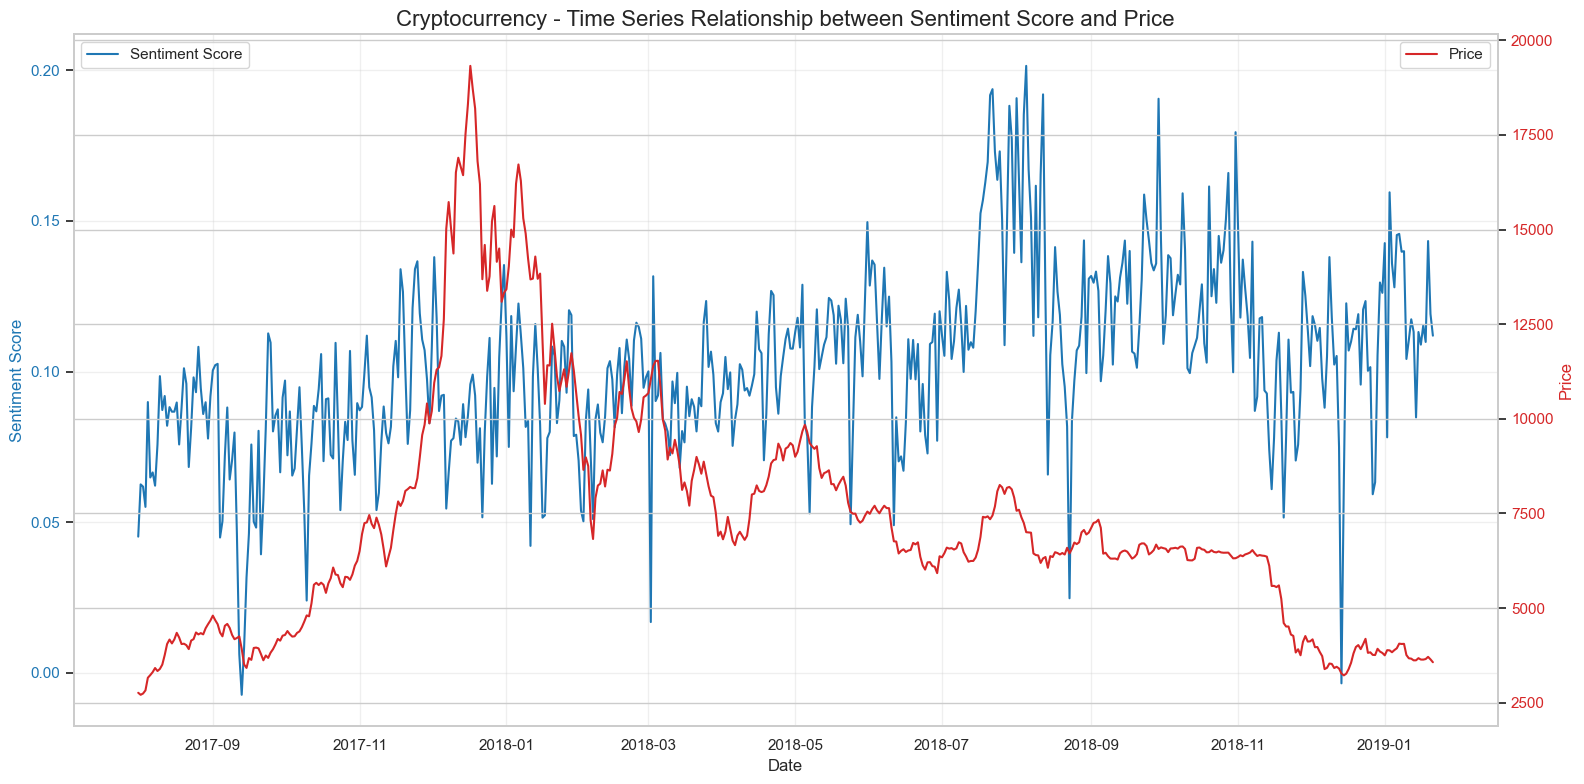


Pearson correlation coefficient between sentiment and price: 0.0021


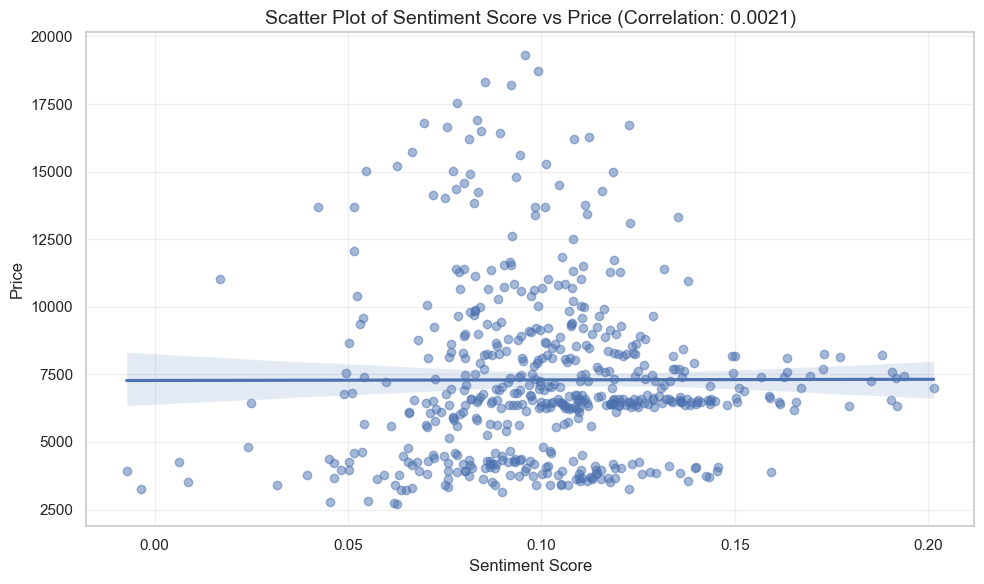


Lag correlation analysis:
Correlation with sentiment leading price:
  - Sentiment leading by 1 days: 0.0017
  - Sentiment leading by 2 days: 0.0002
  - Sentiment leading by 3 days: -0.0036
  - Sentiment leading by 4 days: -0.0066
  - Sentiment leading by 5 days: -0.0049
  - Sentiment leading by 6 days: -0.0045
  - Sentiment leading by 7 days: -0.0075

Correlation with price leading sentiment:
  - Price leading by 1 days: -0.0178
  - Price leading by 2 days: -0.0327
  - Price leading by 3 days: -0.0420
  - Price leading by 4 days: -0.0471
  - Price leading by 5 days: -0.0490
  - Price leading by 6 days: -0.0536
  - Price leading by 7 days: -0.0576


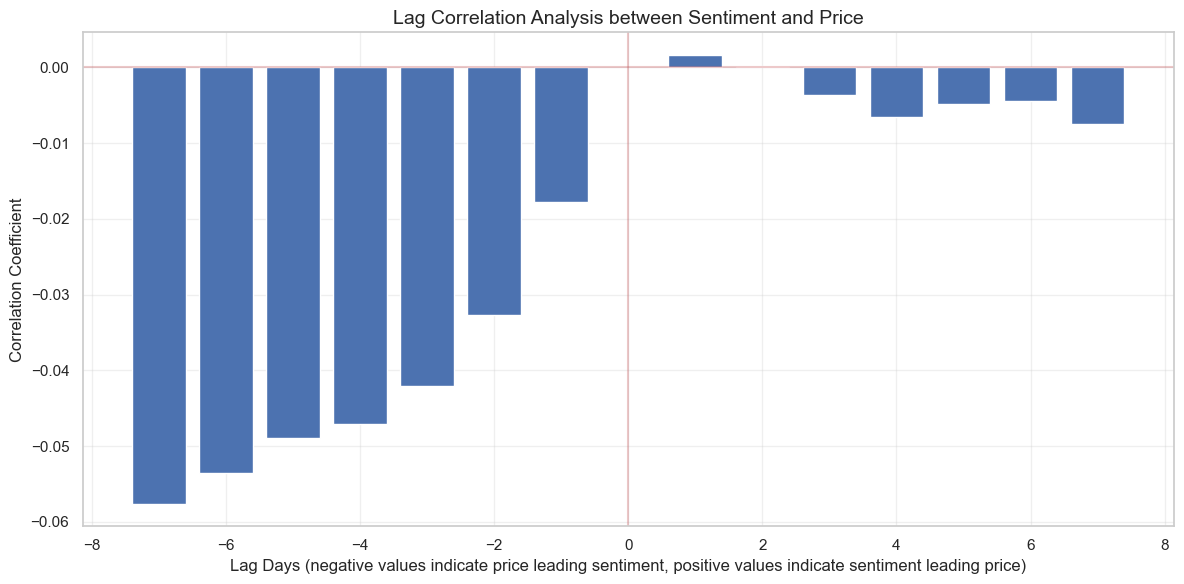


Maximum correlation occurs at lag: -7 days, correlation coefficient: -0.0576
This suggests that price changes may lead sentiment changes by 7 days
Error occurred during analysis: name 'advanced_exploratory_analysis' is not defined
Encountered issues during analysis, unable to generate final dataset

Exploratory data analysis completed!


In [33]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('ggplot')
sns.set(style="whitegrid")


# Main program
print("Starting cryptocurrency sentiment and price data exploratory analysis...")

if __name__ == "__main__":
# Load data
    try:
        df_final = pd.read_csv('df_Final.csv', sep=';', encoding='utf-8')
        print(f"Successfully loaded data, shape: {df_final.shape}")
        
        # Execute core analysis
        result_df = main_analysis(df_final)
        
        if result_df is not None:
            print("Analysis completed, enhanced feature dataset generated")
            print(f"Final dataset shape: {result_df.shape}")
        else:
            print("Encountered issues during analysis, unable to generate final dataset")
            
    except Exception as e:
        print(f"Error loading or analyzing data: {e}")

    print("\nExploratory data analysis completed!")

In [34]:
# Sentiment analysis enhancement example code
import pandas as pd
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob

# Initialize VADER analyzer
sia = SentimentIntensityAnalyzer()

crypto_lexicon = {
    "moon": 4.0,
    "hodl": 2.0,
    "dump": -3.0,
    "fud": -3.0,
    "bullish": 3.0,
    "bearish": -3.0,
    # Add more cryptocurrency-specific vocabulary
}
sia.lexicon.update(crypto_lexicon)

# Apply enhanced sentiment analysis (if original text is available)
if 'tweets_text' in df_final.columns:
    # VADER enhanced analysis
    df_final['vader_enhanced'] = df_final['tweets_text'].apply(
        lambda x: sia.polarity_scores(x)['compound'] if isinstance(x, str) else None
    )
    
    # TextBlob provides another sentiment measure
    df_final['textblob_polarity'] = df_final['tweets_text'].apply(
        lambda x: TextBlob(x).sentiment.polarity if isinstance(x, str) else None
    )
    
    # Sentiment intensity (regardless of positive/negative, only focusing on intensity)
    df_final['sentiment_intensity'] = df_final['vader_enhanced'].abs()

In [35]:
# Modified feature engineering and data preparation code
import pandas as pd
import numpy as np
from datetime import datetime

# 1. Load data
try:
    df_final = pd.read_csv('df_Final.csv', sep=';', encoding='utf-8')
    print(f"Successfully loaded data, original shape: {df_final.shape}")
    
    # 2. Check data types
    print("\nData type check:")
    print(df_final.dtypes)
    
    # 3. Convert date column to datetime type
    df_final['Date'] = pd.to_datetime(df_final['Date'], errors='coerce')
    
    # 4. Check non-numeric columns and process appropriately
    object_columns = df_final.select_dtypes(include=['object']).columns.tolist()
    if len(object_columns) > 0:
        print(f"\nFound object type columns: {object_columns}")
        # Remove date column (if it appears in object columns)
        if 'Date' in object_columns:
            object_columns.remove('Date')
        
        # Try to convert remaining object columns to numeric
        for col in object_columns:
            try:
                df_final[col] = pd.to_numeric(df_final[col], errors='coerce')
                print(f"  - Successfully converted column '{col}' to numeric type")
            except Exception as e:
                print(f"  - Unable to convert column '{col}' to numeric type: {e}")
    
    # 5. Group by date and calculate daily averages (using only numeric columns)
    print("\nCreating daily summary data...")
    # Identify numeric columns
    numeric_columns = df_final.select_dtypes(include=['number']).columns.tolist()
    print(f"Numeric columns ({len(numeric_columns)}): {numeric_columns[:5]}...")  # Only show first 5
    
    # Group by date and calculate means (using only numeric columns)
    df_daily = df_final.groupby(df_final['Date'].dt.date)[numeric_columns].mean().reset_index()
    print(f"Daily summary data shape: {df_daily.shape}")
    
    # 6. Ensure date column is datetime type
    df_daily['Date'] = pd.to_datetime(df_daily['Date'])
    
    # 7. Create features
    print("\nCreating features...")
    
    # 7.1 Lag features - based on finding that price leads sentiment
    lag_columns = []  # Track created lag columns
    for i in range(1, 10):
        # Find price columns (could be 'Open', 'Close', 'Price', etc.)
        price_cols = [col for col in numeric_columns if any(term in col.lower() for term in ['open', 'close', 'price'])]
        if price_cols:
            price_col = price_cols[0]  # Use the first matching price column
            col_name = f'price_lag_{i}'
            df_daily[col_name] = df_daily[price_col].shift(i)
            lag_columns.append(col_name)
            
            # Price change rate
            col_name = f'price_change_{i}'
            df_daily[col_name] = df_daily[price_col].pct_change(i) * 100
            lag_columns.append(col_name)
        
        # Find sentiment columns
        sentiment_cols = [col for col in numeric_columns if any(term in col.lower() for term in ['sentiment', 'compound'])]
        if sentiment_cols:
            sentiment_col = sentiment_cols[0]  # Use the first matching sentiment column
            col_name = f'sentiment_lag_{i}'
            df_daily[col_name] = df_daily[sentiment_col].shift(i)
            lag_columns.append(col_name)
    
    # 7.2 Volatility features
    windows = [3, 7, 14]  # Use shorter windows to reduce NaN
    volatility_columns = []
    for window in windows:
        # Price volatility
        if price_cols:
            col_name = f'price_volatility_{window}d'
            df_daily[col_name] = df_daily[price_col].pct_change().rolling(window).std()
            volatility_columns.append(col_name)
        
        # Sentiment volatility
        if sentiment_cols:
            col_name = f'sentiment_volatility_{window}d'
            df_daily[col_name] = df_daily[sentiment_col].rolling(window).std()
            volatility_columns.append(col_name)
    
    # 7.3 Moving average features
    ma_columns = []
    for window in windows:
        # Price moving average
        if price_cols:
            col_name = f'price_ma_{window}d'
            df_daily[col_name] = df_daily[price_col].rolling(window).mean()
            ma_columns.append(col_name)
        
        # Sentiment moving average
        if sentiment_cols:
            col_name = f'sentiment_ma_{window}d'
            df_daily[col_name] = df_daily[sentiment_col].rolling(window).mean()
            ma_columns.append(col_name)
    
    # 7.4 Trend features
    if price_cols and 'price_ma_14d' in df_daily.columns:  # Use 14-day moving average to define trend
        df_daily['trend'] = 'sideways'
        df_daily.loc[df_daily[price_col] > df_daily['price_ma_14d'] * 1.05, 'trend'] = 'uptrend'
        df_daily.loc[df_daily[price_col] < df_daily['price_ma_14d'] * 0.95, 'trend'] = 'downtrend'
        
        # Convert trend to numeric feature
        trend_map = {'uptrend': 1, 'sideways': 0, 'downtrend': -1}
        df_daily['trend_numeric'] = df_daily['trend'].map(trend_map)
    
    # 7.5 Extreme sentiment indicator
    if sentiment_cols:
        sentiment_mean = df_daily[sentiment_col].mean()
        sentiment_std = df_daily[sentiment_col].std()
        df_daily['extreme_sentiment'] = 0  # Normal sentiment
        df_daily.loc[df_daily[sentiment_col] > sentiment_mean + 1.5 * sentiment_std, 'extreme_sentiment'] = 1  # Extreme positive
        df_daily.loc[df_daily[sentiment_col] < sentiment_mean - 1.5 * sentiment_std, 'extreme_sentiment'] = -1  # Extreme negative
    
    # 7.6 Cross features
    if price_cols and sentiment_cols:
        df_daily['price_sentiment_ratio'] = df_daily[price_col] / (df_daily[sentiment_col].abs() + 0.01)  # Add 0.01 to avoid division by zero
        
        if 'price_change_1' in df_daily.columns:
            df_daily['price_change_sentiment_product'] = df_daily['price_change_1'] * df_daily[sentiment_col]
    
    # 8. Remove NaN and save feature dataset
    print("\nRemoving missing values and saving dataset...")
    # Use forward fill to handle NaN (suitable for time series)
    df_daily_filled = df_daily.fillna(method='ffill')
    # Then use backward fill to handle NaN at the beginning
    df_daily_filled = df_daily_filled.fillna(method='bfill')
    # Finally use 0 for any remaining NaN
    df_features = df_daily_filled.fillna(0)
    
    # Save processed dataset
    df_features.to_csv('crypto_features_clean.csv', index=False)
    print(f"Feature engineering completed, generated {df_features.shape[1]} features, dataset shape: {df_features.shape}")
    print(f"Data saved to 'crypto_features_clean.csv'")
    
    # Output feature list for reference
    print("\nCreated feature list:")
    print(f"- Lag features: {len(lag_columns)} columns")
    print(f"- Volatility features: {len(volatility_columns)} columns")
    print(f"- Moving average features: {len(ma_columns)} columns")
    print("- Trend features: 'trend', 'trend_numeric'")
    print("- Sentiment features: 'extreme_sentiment'")
    
except Exception as e:
    import traceback
    print(f"Error encountered during processing: {e}")
    traceback.print_exc()

Successfully loaded data, original shape: (12936, 16)

Data type check:
Date                       object
Compound_Score            float64
Total Volume of Tweets    float64
Count_Negatives           float64
Count_Positives           float64
Count_Neutrals            float64
Sent_Negatives            float64
Sent_Positives            float64
Count_News                float64
Count_Bots                float64
Open                      float64
High                      float64
Low                       float64
Close                     float64
Volume (BTC)               object
Volume (Currency)          object
dtype: object

Found object type columns: ['Volume (BTC)', 'Volume (Currency)']
  - Successfully converted column 'Volume (BTC)' to numeric type
  - Successfully converted column 'Volume (Currency)' to numeric type

Creating daily summary data...
Numeric columns (15): ['Compound_Score', 'Total Volume of Tweets', 'Count_Negatives', 'Count_Positives', 'Count_Neutrals']...
Daily summa

In [36]:
# Data preparation code
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Task 1: Predict future sentiment
X_sentiment = df_features.drop(['Compound_Score', 'Date', 'trend'], axis=1)
y_sentiment = df_features['Compound_Score']

# Task 2: Predict future price
# We try to predict price change 1 day in the future
df_features['future_price_change_1d'] = df_features['Open'].pct_change(-1)  # -1 means 1 day in the future
X_price = df_features.drop(['future_price_change_1d', 'Date', 'trend'], axis=1)
y_price = df_features['future_price_change_1d']

# Remove NaN
X_sentiment = X_sentiment.fillna(0)
y_sentiment = y_sentiment.fillna(0)
X_price = X_price.fillna(0)
y_price = y_price.fillna(0)

# Data standardization
scaler_X_sentiment = StandardScaler()
X_sentiment_scaled = scaler_X_sentiment.fit_transform(X_sentiment)

scaler_X_price = StandardScaler()
X_price_scaled = scaler_X_price.fit_transform(X_price)

# Data splitting - using time series split
# For time series, it's better to split by time order rather than randomly
train_size = int(len(X_sentiment_scaled) * 0.8)

# Sentiment prediction task
X_train_sentiment = X_sentiment_scaled[:train_size]
X_test_sentiment = X_sentiment_scaled[train_size:]
y_train_sentiment = y_sentiment[:train_size]
y_test_sentiment = y_sentiment[train_size:]

# Price prediction task
X_train_price = X_price_scaled[:train_size]
X_test_price = X_price_scaled[train_size:]
y_train_price = y_price[:train_size]
y_test_price = y_price[train_size:]

print("Data preparation completed.")
print(f"Training set size: {len(X_train_sentiment)}, Test set size: {len(X_test_sentiment)}")

Data preparation completed.
Training set size: 431, Test set size: 108
